## Previsao de Embarque 
- Simples 
- Sem Serie Temporal
- Regressao Linear
- Random Forest
- Com Grid Search
- Bagging, Stacking e Boosting

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, StackingRegressor, GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.datasets import make_regression
import datetime as dt

import warnings

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import RandomizedSearchCV
from IPython.display import display
from pprint import pprint
from math import sqrt

from variables import day_of_week_translator, feriados, vesperas

#from shutil import unpack_archive
#unpack_archive('./df_input.zip', './')

## Filtro de Onibus e definicoes de features/target

In [2]:
# Reading Data file (geolocalized)
data = pd.read_csv('../data_input_zerofill_2018.csv')

data['data_hora'] = pd.to_datetime(data['data_hora'], format='%Y/%m/%d %H:%M:%S', errors='coerce')
data_model = data.loc[data.data_hora.dt.year == 2018].copy()

#d_ano,  estao disponiveis para inserir once eu tive mais de 1 ano de dados
feature_names = [
    'hour_sin', 'hour_cos', 
    'd_mes', 'd_ano', 'mes', 'semana_do_mes', 
    'domingo','segunda', 'terca', 'quarta', 'quinta', 'sexta', 'sabado', 
    'feriado', 'vespera_feriado']

target = 'validations_per_hour'

busline_filter = 41

In [3]:
data_model

,linha,data_hora,validations_per_hour,d_semana,hour_sin,hour_cos,hora,d_mes,d_ano,mes,semana_do_mes
63,1,2018-01-01 00:00:00,29,0,0.000000e+00,1.000000,0,1,1,1,1
64,1,2018-01-01 01:00:00,58,0,2.697968e-01,0.962917,1,1,1,1,1
65,1,2018-01-01 02:00:00,42,0,5.195840e-01,0.854419,2,1,1,1,1
66,1,2018-01-01 03:00:00,49,0,7.308360e-01,0.682553,3,1,1,1,1
67,1,2018-01-01 04:00:00,112,0,8.878852e-01,0.460065,4,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...
1229961,999,2018-07-02 21:00:00,5,0,-5.195840e-01,0.854419,21,2,183,7,1
1229962,999,2018-07-02 22:00:00,8,0,-2.697968e-01,0.962917,22,2,183,7,1
1229963,999,2018-07-02 23:00:00,1,0,-2.449294e-16,1.000000,23,2,183,7,1
1229964,999,2018-07-30 20:00:00,2,0,-7.308360e-01,0.682553,20,30,211,7,5


In [4]:
one_hot_encoder = OneHotEncoder(sparse=False)

data_model[['domingo','segunda', 'terca', 'quarta', 'quinta', 'sexta', 'sabado']] = one_hot_encoder.fit_transform(data_model['d_semana'].values.reshape(-1,1))
data_model['feriado'] = [1 if any((x[0] == d and x[1] == m) for (_, d, m) in feriados) else 0 for x in list(zip(data_model.d_mes, data_model.mes))]
data_model['vespera_feriado'] = [1 if any((x[0] == d and x[1] == m) for (_, d, m) in vesperas) else 0 for x in list(zip(data_model.d_mes, data_model.mes))]

top100_linhas = data_model.groupby(data_model.linha).sum().reset_index().sort_values('validations_per_hour', ascending=False).index[:100].to_list()
top100_linhas_data_model = data_model[data_model.linha.isin(top100_linhas)]

top100_linhas_data_model.to_csv("../dados-para-modelos/2018/top100_linhas_data_model_2018.csv", index=False)

line_data_model = data_model.loc[data_model['linha'] == busline_filter].copy()

#sns.set(rc={'figure.figsize':(15,10)})
# sns.heatmap(top100_linhas_data_model.corr()[['validations_per_hour']].sort_values(by='validations_per_hour', ascending=False)
# , vmin=-1, vmax=1, annot=True)

In [5]:
top100_linhas_data_model

,linha,data_hora,validations_per_hour,d_semana,hour_sin,hour_cos,hora,d_mes,d_ano,mes,semana_do_mes,domingo,segunda,terca,quarta,quinta,sexta,sabado,feriado,vespera_feriado
63,1,2018-01-01 00:00:00,29,0,0.000000e+00,1.000000,0,1,1,1,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
64,1,2018-01-01 01:00:00,58,0,2.697968e-01,0.962917,1,1,1,1,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
65,1,2018-01-01 02:00:00,42,0,5.195840e-01,0.854419,2,1,1,1,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
66,1,2018-01-01 03:00:00,49,0,7.308360e-01,0.682553,3,1,1,1,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
67,1,2018-01-01 04:00:00,112,0,8.878852e-01,0.460065,4,1,1,1,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
658856,361,2018-07-31 19:00:00,65,1,-8.878852e-01,0.460065,19,31,212,7,5,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0
658857,361,2018-07-31 20:00:00,31,1,-7.308360e-01,0.682553,20,31,212,7,5,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0
658858,361,2018-07-31 21:00:00,23,1,-5.195840e-01,0.854419,21,31,212,7,5,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0
658859,361,2018-07-31 22:00:00,26,1,-2.697968e-01,0.962917,22,31,212,7,5,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0


In [6]:
#display(X)

In [7]:
#display(y)

---------------------------------------------------------------------------- Fim Setup ----------------------------------------------------------------------------  
# Criacao dos Modelos

In [8]:
model_list = []

In [9]:
def get_performance(model):
    y_test_predict = model.predict(X_test)
    mse = mean_squared_error(Y_test, y_test_predict)
    rmse = (np.sqrt(mse))
    r2 = r2_score(Y_test, y_test_predict)
    mae = mean_absolute_error(Y_test, y_test_predict)
    mape = mean_absolute_percentage_error(Y_test, y_test_predict) * 100
    performance_scoring = [
        r2,
        rmse,
        mae,
        mape
    ]
    #performance_scoring = pd.DataFrame(performance_scoring,columns=['Metrica', 'Score'])
    #performance_scoring['Score'] = performance_scoring['Score'].astype('float64')
    return performance_scoring

### Grid Search

In [10]:
LinearRegressionModel = LinearRegression()
RandomForestModel = RandomForestRegressor()

#### Linear Regression Model Parameters

In [11]:
# print("Linear Regression  Params ----> ")
# pprint(LinearRegressionModel.get_params())

copy_X = [True, False]
fit_intercept = [True, False]
n_jobs = [2, 4, 6, 8]
normalize = [True, False]

# Create the random grid
random_grid_linearregression = {'copy_X': copy_X, 'fit_intercept': fit_intercept, 'n_jobs': n_jobs, 'normalize': normalize}

#### Random Forest Model Parameters

In [12]:
# print("Random Forest Model Params ----> ")
# pprint(RandomForestModel.get_params())

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 20, stop = 1000, num = 10)]

n_jobs = [2, 4, 6, 8]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid_randomforest = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'n_jobs': n_jobs}

In [13]:
X = line_data_model.filter(feature_names, axis=1)
y = line_data_model.validations_per_hour

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
LinearRegressionModel = LinearRegression()
RandomForestModel = RandomForestRegressor()
gridsearch_result_randomforest = RandomizedSearchCV(estimator = RandomForestModel, param_distributions = random_grid_randomforest, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
gridsearch_result_linearregression = RandomizedSearchCV(estimator = LinearRegressionModel, param_distributions = random_grid_linearregression, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.2, random_state=5)

gridsearch_result_randomforest.fit(X_train, Y_train)
gridsearch_result_linearregression.fit(X_train, Y_train)

print("Random Forest Best Parameters -----> ")
pprint(gridsearch_result_randomforest.best_params_)

print("Linear Regression Best Parameters -----> ")
pprint(gridsearch_result_linearregression.best_params_)

gridsearched_random_randomforest = gridsearch_result_randomforest.best_estimator_
gridsearched_random_linearregression = gridsearch_result_linearregression.best_estimator_

default_linearregression_model = LinearRegressionModel.fit(X_train, Y_train)
default_randomforest_model = RandomForestModel.fit(X_train, Y_train)

GridSearchedRandomForestModelPipeline = make_pipeline(gridsearched_random_randomforest)
DefaultRandomForestModelPipeline = make_pipeline(default_randomforest_model)


Fitting 3 folds for each of 100 candidates, totalling 300 fits


/Users/victormedeiros/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 32 is smaller than n_iter=100. Running 32 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 32 candidates, totalling 96 fits
Random Forest Best Parameters -----> 
{'bootstrap': False,
 'max_depth': 110,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 455,
 'n_jobs': 2}
Linear Regression Best Parameters -----> 
{'copy_X': True, 'fit_intercept': True, 'n_jobs': 2, 'normalize': True}


In [14]:
performance_default_randomforest_model = get_performance(default_randomforest_model)
performance_gridsearched_randomforest_model = get_performance(gridsearched_random_randomforest)
performance_gridsearched_linearregression_model = get_performance(gridsearched_random_linearregression)
performance_default_linearregression_model = get_performance(default_linearregression_model)

print("\n----------------------------------------------------\n")
print('Regressao Linear [DEFAULT]: \n', performance_default_linearregression_model)
print("\n----------------------------------------------------\n")
print('Random Forest [DEFAULT]: \n', performance_default_randomforest_model)
print("\n----------------------------------------------------\n")
print('Regressao Linear [GRID SEARCH]: \n', performance_gridsearched_linearregression_model)
print("\n----------------------------------------------------\n")
print('Random Forest [GRID SEARCH]: \n', performance_gridsearched_randomforest_model)
print("\n----------------------------------------------------\n")

performance_total = [performance_default_linearregression_model,
    performance_default_randomforest_model,
    performance_gridsearched_linearregression_model,
    performance_gridsearched_randomforest_model]

performance_total = pd.DataFrame.from_records(performance_total, columns=['R2', 'RMSE', 'MAE', 'MAPE'], 
    index=['LinearReg Default', 'RandomForest Default', 'LinearReg GridSearched', 'RandomForest GridSearched'])
performance_total


----------------------------------------------------

Regressao Linear [DEFAULT]: 
 [0.3743509591889088, 280.9767341149054, 213.86895393960694, 185.78662380013702]

----------------------------------------------------

Random Forest [DEFAULT]: 
 [0.9220957275898235, 99.14837635103838, 61.57475319590923, 38.62647177942875]

----------------------------------------------------

Regressao Linear [GRID SEARCH]: 
 [0.3743509591889086, 280.9767341149054, 213.86895393960702, 185.78662380013768]

----------------------------------------------------

Random Forest [GRID SEARCH]: 
 [0.9293502764346737, 94.41917516341336, 67.26351295982168, 51.04929456122327]

----------------------------------------------------



,R2,RMSE,MAE,MAPE
LinearReg Default,0.374351,280.976734,213.868954,185.786624
RandomForest Default,0.922096,99.148376,61.574753,38.626472
LinearReg GridSearched,0.374351,280.976734,213.868954,185.786624
RandomForest GridSearched,0.929350,94.419175,67.263513,51.049295


## BAGGING

In [15]:
#X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.2, random_state=5)
warnings.filterwarnings("ignore") # To ignore warnings
n_jobs = -1 # This parameter conrols the parallel processing. -1 means using all processors.
random_state = 42 # This parameter controls the randomness of the data. Using some int value to get same results everytime this code is run
models_scores = [] # To store model scores               

def bagging_model(estimator):
    """
    I/P
    estimator: The base estimator from which the ensemble is grown.
    O/P
    br_y_pred: Predictions on test data for the base estimator.
    
    """
    regr = BaggingRegressor(base_estimator=estimator,
                            n_estimators=10,
                            max_samples=1.0,
                            bootstrap=True, # Samples are drawn with replacement
                            n_jobs= n_jobs,
                            random_state=random_state).fit(X_train, Y_train)

    br_y_pred = regr.predict(X_test)

    performance = get_performance(regr)
    
    print(f'Performance for base estimator {regr.base_estimator_} = {performance}\n')

    return regr, performance

LinearRegressionModelPipeline = make_pipeline(gridsearched_random_linearregression)
RandomForestModelPipeline = make_pipeline(gridsearched_random_randomforest)


bagging_lr_model, performance_bagging_lr_model = bagging_model(LinearRegressionModelPipeline)
bagging_rf_model, performance_bagging_rf_model = bagging_model(RandomForestModelPipeline)

df2 = pd.DataFrame([performance_bagging_lr_model, performance_bagging_rf_model], columns=['R2','RMSE','MAE', 'MAPE'], 
    index=['LinearRegression Bagging', 'RandomForest Bagging'])
performance_total = pd.concat([df2, performance_total])

BaggingLinearRegressionModelPipeline = make_pipeline(bagging_lr_model)
BaggingRandomForestModelPipeline = make_pipeline(bagging_rf_model)


Performance for base estimator Pipeline(steps=[('linearregression', LinearRegression())]) = [0.3747738606483336, 280.8817563001143, 214.32735615374094, 187.5237971576074]

Performance for base estimator Pipeline(steps=[('randomforestregressor', RandomForestRegressor())]) = [0.921357848029156, 99.61681754715624, 61.406101471949626, 38.59372594400279]



# BOOSTING

In [16]:
gradient_boosting_regressor= GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state = random_state)

gradient_boosting_regressor.fit(X_train, Y_train)

performance = get_performance(gradient_boosting_regressor)

df2 = pd.DataFrame([performance], columns=['R2','RMSE','MAE', 'MAPE'], 
    index=['GradientBoostingRegressor'])

GradientBoostingModelPipeline = make_pipeline(gradient_boosting_regressor)

performance_total = pd.concat([df2, performance_total])


# STACKING

In [17]:
estimators = [
    ('gridseached_randomforest', GridSearchedRandomForestModelPipeline),
    ('bagging_randomforest',BaggingRandomForestModelPipeline),
    ('gradient_boosting', GradientBoostingModelPipeline), 
    ('random_forest_default', DefaultRandomForestModelPipeline)
]

stack = StackingRegressor(estimators=estimators, final_estimator=DefaultRandomForestModelPipeline, cv= 5, n_jobs= n_jobs, passthrough = True)

stack.fit(X_train, Y_train)

performance = get_performance(stack)

df2 = pd.DataFrame([performance], columns=['R2','RMSE','MAE', 'MAPE'], 
    index=['Stacking Regressors'])

performance_total = pd.concat([df2, performance_total])

In [18]:
performance_total = performance_total.sort_values('MAE', ascending=True)
performance_total.to_csv('../performances/2018/performance_total_linha'+str(busline_filter)+'.csv', index=False)

In [19]:
performance_total

,R2,RMSE,MAE,MAPE
Stacking Regressors,0.949266,80.011877,50.279404,30.887059
GradientBoostingRegressor,0.945164,83.183808,54.973409,39.182614
RandomForest Bagging,0.921358,99.616818,61.406101,38.593726
RandomForest Default,0.922096,99.148376,61.574753,38.626472
RandomForest GridSearched,0.929350,94.419175,67.263513,51.049295
LinearReg Default,0.374351,280.976734,213.868954,185.786624
LinearReg GridSearched,0.374351,280.976734,213.868954,185.786624
LinearRegression Bagging,0.374774,280.881756,214.327356,187.523797


### Todos os modelos treinados dentro de *model_list*

In [69]:
model_list = [
    stack,
    gradient_boosting_regressor,
    bagging_rf_model,
    default_randomforest_model,
    gridsearch_result_randomforest,
    #default_linearregression_model,
    #gridsearch_result_linearregression,
    #bagging_lr_model,
]

## Treinar com 1 mes, prever N semanas

In [70]:
# Jan, Fev, Mar, Abril, Maio
# treina com mar, preve 2 semanas de abril

mes_de_treino = 3
mes_de_previsao = 4

line_mes_data_model = line_data_model[line_data_model.mes == mes_de_treino]

line_mes_data_model_predict = line_data_model[line_data_model.mes == mes_de_previsao]

df_prev = line_mes_data_model_predict[line_mes_data_model_predict.semana_do_mes <  2].filter(feature_names, axis = 1)
real_values = pd.DataFrame(line_mes_data_model_predict[line_mes_data_model_predict.semana_do_mes <  2].validations_per_hour)

X = line_mes_data_model.filter(feature_names, axis=1)
y = line_mes_data_model.validations_per_hour
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.2, random_state=5)

predictions = [[],[],[],[], []]
performances = list()
df_prev
for i, model in enumerate(model_list):
        model.fit(X_train, Y_train)
        performances.append(get_performance(model))

        for index, row in df_prev.iterrows():
            predictions[i].append(model.predict([row])[0])

df_performance = pd.DataFrame(performances)
df_performance.to_csv('../performances/2018/linha'+str(busline_filter)+'_1mes('+str(mes_de_treino)+')_1semanas('+str(mes_de_previsao)+')_performance.csv', index=False)
df_predict_dados = real_values
df_predict_dados['validations_per_hour_predicted'] = predictions[0]
df_predict_dados.to_csv('../predict-vs-real/2018/linha'+str(busline_filter)+'_1mes('+str(mes_de_treino)+')_1semanas('+str(mes_de_previsao)+')_predict.csv', index=False)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


### Treinar com (N-Y) meses, Prever mes (N)

In [71]:
predictions = []
performances = [[],[],[],[],[],[],[],[]]

df_treinamento = line_data_model[line_data_model.mes < 6].copy()
df_previsao = line_data_model[line_data_model.mes == 6].loc[line_data_model.d_mes < 8].copy()
df_prev = df_previsao.filter(feature_names, axis = 1)
df_results = df_previsao.filter('validations_per_hour', axis = 1)

print(df_results.__len__())

X = df_treinamento.filter(feature_names, axis=1)
y = df_treinamento.validations_per_hour
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.2, random_state=5)


stack.fit(X_train, Y_train)
# performances[i].append(get_performance(stack))

for index, row in df_prev.iterrows():
    predictions.append(stack.predict([row])[0])

df_results = df_previsao.validations_per_hour

df_performance = pd.DataFrame(performances)
df_performance.to_csv('../performances/2020/performance_9_meses_predict_10th_stacking.csv', index=False)




168


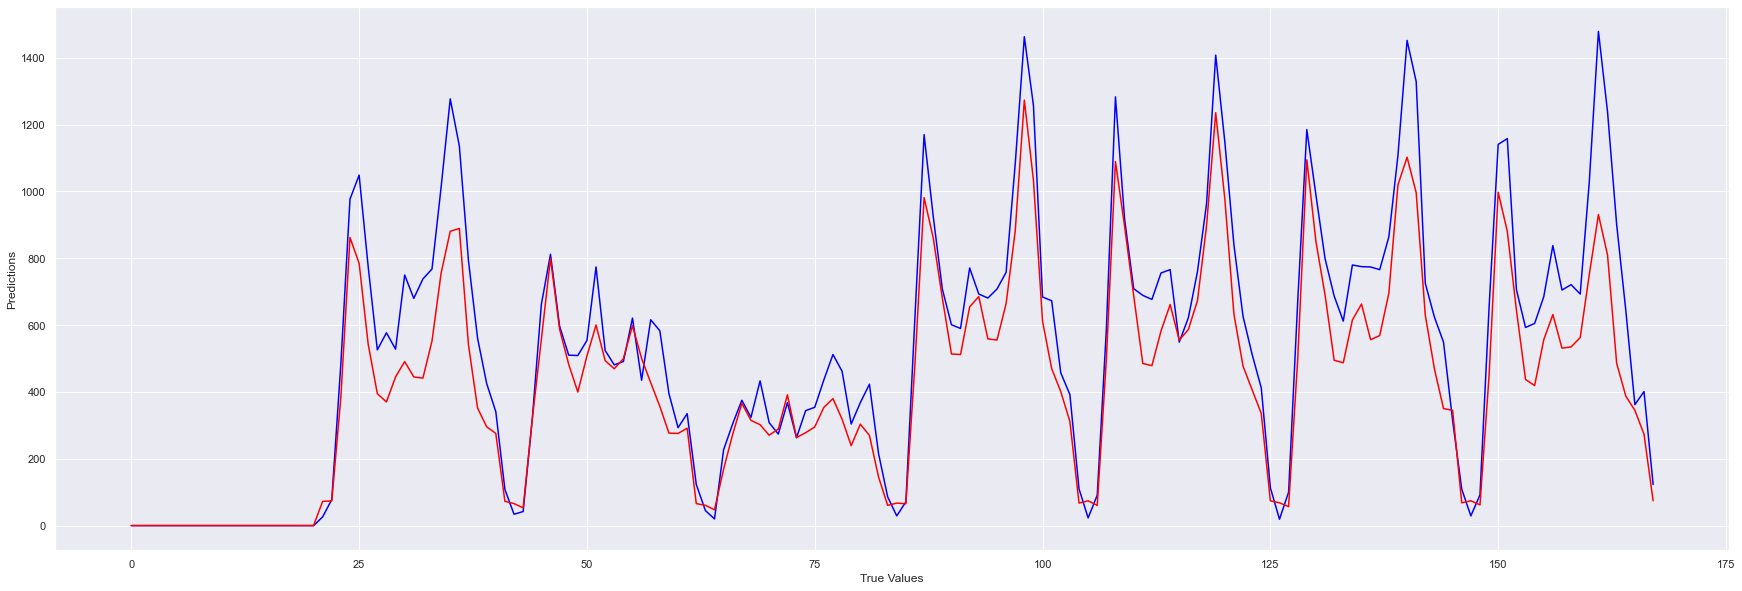

In [72]:
# 168 == quantidade de horas previstas em 1 semana
plt_size = 168

plt.figure(figsize=(30, 10))
plt.plot(range(df_results.size), df_results.values, color='blue')
plt.plot(range(predictions.__len__()), predictions, color='red')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()

In [ ]:
performances

## Ranking Linhas de Onibus

In [ ]:

# print(data_model.linha.value_counts(ascending=True)[data_model['linha'].value_counts() < 100])

# linha_lista = data_model.linha.unique()
# linha_lista = linha_lista[:10]
res_map = list()
top100_linhas = data_model.linha.value_counts().index[:100]

for linha in top100_linhas:
    
    currentLinhaData = top100_linhas_data_model.loc[top100_linhas_data_model['linha'] == linha].copy()
    X = currentLinhaData.filter(feature_names, axis=1)
    y = currentLinhaData.validations_per_hour
    X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.2, random_state=5)
    for model in model_list:
        model.fit(X_train, Y_train)
        performance = get_performance(model)
        performance.insert(0, linha)
        res_map.append(performance)
res_map = pd.DataFrame(res_map, columns=["Linha", "R2", "RMSE", "MAE", 'MAPE'])
r = res_map.sort_values('MAE', ascending=True)
r.to_csv("../performances/2018/ranking_top100_2018.csv", index=False)



In [ ]:
# res_map = pd.DataFrame(res_map,columns=['Linha', 
#     # '[LR][DEF]R2', '[LR][DF]RMSE', '[LR][DF]MAE',
#     '[RF][GS]R2', '[RF][GS]RMSE', '[RF][GS]MAE',
#     # '[LR][BAG]R2', '[LR][BAG]RMSE', '[LR][BAG]MAE',
#     '[RF][BAG]R2', '[RF][BAG]RMSE', '[RF][BAG]MAE',
#     '[STK]R2', '[STK]RMSE', '[STK]MAE',
#     # '[BOS]R2', '[BOS]RMSE', '[BOS]MAE' 
#     ])
res_map = pd.DataFrame(res_map,columns=['Linha','R2', 'RMSE', 'MAE', 'MAPE'])

#performance_scoring['Score'] = performance_scoring['Score'].astype('float64')
res_map = res_map.sort_values('MAE', ascending=True).reset_index(drop=True)
res_map = res_map.drop_duplicates(subset='Linha', keep="first").reset_index(drop=True)
res_map.to_csv('../top100linhas_rank_2018.csv', index=False)
res_map

In [ ]:
# model_list = [
#     stack,
#     gradient_boosting_regressor,
#     bagging_rf_model,
#     default_randomforest_model,
#     #default_linearregression_model,
#     #gridsearched_result_linearregression,
#     #gridsearched_random_randomforest,
#     #bagging_lr_model,
# ]

sample = X.sample(n=1)
sample

print('LINHA UTILIZADA PARA OS TESTES: ', busline_filter)

print("\nUtilizando sample aleatorio de dado para teste de previsao: ")

display(data_model.loc[sample.index[0]:sample.index[0]])

res = stack.predict(sample)
print("Stacked Regressor -> resultado do predict de test: ", res)

res = gradient_boosting_regressor.predict(sample)
print("gradient_boosting_regressor -> resultado do predict de test: ", res)

res = bagging_rf_model.predict(sample)
print("bagging_rf_model -> resultado do predict de test: ", res)

res = gridsearched_random_randomforest.predict(sample)
print("Random Forest Best Grid Searched -> resultado do predict de test: ", res)

res = default_randomforest_model.predict(sample)
print("Random Forest Default -> resultado do predict de test: ", res)

res = bagging_lr_model.predict(sample)
print("bagging_lr_model -> resultado do predict de test: ", res)

res = default_linearregression_model.predict(sample)
print("Regressao Linear Default -> resultado do predict de test: ", res)

res = gridsearched_random_linearregression.predict(sample)
print("Regressao Linear Best Grid Searched -> resultado do predict de test: ", res)